In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [115]:
t = 0.0
δ_true = 0.1

#=
# For placing the vortices randomly
Nv_cluster = 3 #3
Nv_per_cluster = 1 #5
Nv_true = Nv_cluster*Nv_per_cluster 

xr = (-1.5,1.5)
yr = (0.1,1.0)
Γr = (0.0,2.0)


σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
=#

#=
Prescribed placement
=#
#zv = [0.0+0.75im]
#Γv = [1.0]
zv = [0.0+0.75im,0.75+0.5im]
Γv = [1.2,1.0]
#zv = [-1.0+0.75im,0.25+0.5im,0.75+0.75im]
#Γv = [1.0,1.2,1.4]
Nv_true = length(zv)

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  length(zv)
=#


2

### Create sensors

In [306]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 3
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 5
ϵsens = 0.0
lowerrow = range(-1.5,1.5,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

#### Set up the observer for the truth data

In [307]:
config_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state(vort,config_true)


obs_true = PressureObservations(sens,config_true);

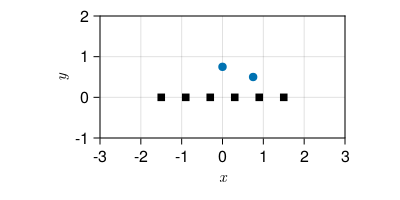

In [308]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f;limits=(-3,3,-1,2), xlabel = L"x",ylabel = L"y", aspect=DataAspect())
show_vortices!(ax,x_true,obs_true)
plot_sensors!(ax,obs)
f

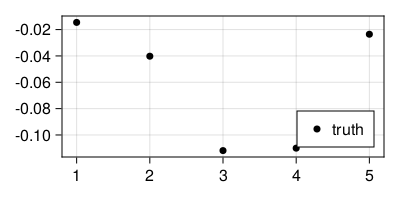

In [309]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f)
ystar = observations(x_true,t,obs_true);
plot_sensor_data!(ax,ystar,obs_true)
f

## Vortex estimation

In [359]:
Nv_estimator = 2
δ = 0.1

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)

# measurement noise
ϵmeas = 5e-4 #1e-3

# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,1.5)
Γr = (0.2,2.0)

obs = PressureObservations(sens,config_estimator);

Σϵ = Diagonal(ϵmeas^2*ones(length(sens)));

### MCMC approach

In [361]:
## Parallel tempering ##
# Set the number of chains and the inverse "temperature" of each chain
nchain = 5
β = 2.0.^(range(0,-3,length=nchain));

In [362]:
Ntrial = 10000
propvarX = 0.01^2 # 0.01^2
propvarY = 0.01^2 # 0.01^2
propvarΓ = 0.01^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

# scale the covariance of each chain by its temperature
propvars = [propvar/β[i] for i = 1:nchain];

In [363]:
#xseed = copy(x_true)
xseed = generate_random_state(xr,yr,Γr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]

x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> normal_loglikelihood(x,t,ystar,Σϵ,obs),propvars;β=β,process_state=x->state_filter!(x,obs));

In [364]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.03579284143171366
 0.03279344131173765
 0.030193961207758448
 0.033193361327734455
 0.033593281343731254

In [365]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.29246064623032314
 0.26500389711613404
 0.26913779210314265
 0.24901497241922774

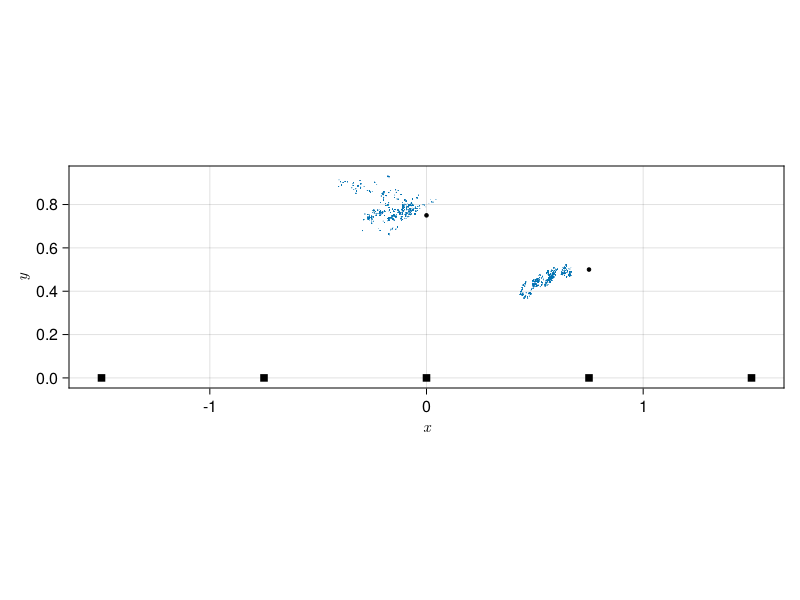

In [366]:
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,ylims=(-1,2))
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=5,color=:black,strokewidth=1)
plot_sensors!(ax,obs)
f

#### Build from the first chain 

In [367]:
β = 2.0.^(range(0,-3,length=nchain));

In [382]:
Ntrial = 400000
propvarX = 0.005^2 # 0.01^2
propvarY = 0.005^2 # 0.01^2
propvarΓ = 0.005^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

propvars = [propvar/β[i] for i = 1:nchain];

In [383]:
xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,x -> normal_loglikelihood(x,t,ystar,Σϵ,obs),propvars;β=β,process_state=x->state_filter!(x,obs));

In [384]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.17094914525427374
 0.17331413342933286
 0.17249913750431248
 0.17167414162929184
 0.1715391423042885

In [385]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.30508542552338175
 0.3218296137080412
 0.3784815947853558
 0.3290357185426517

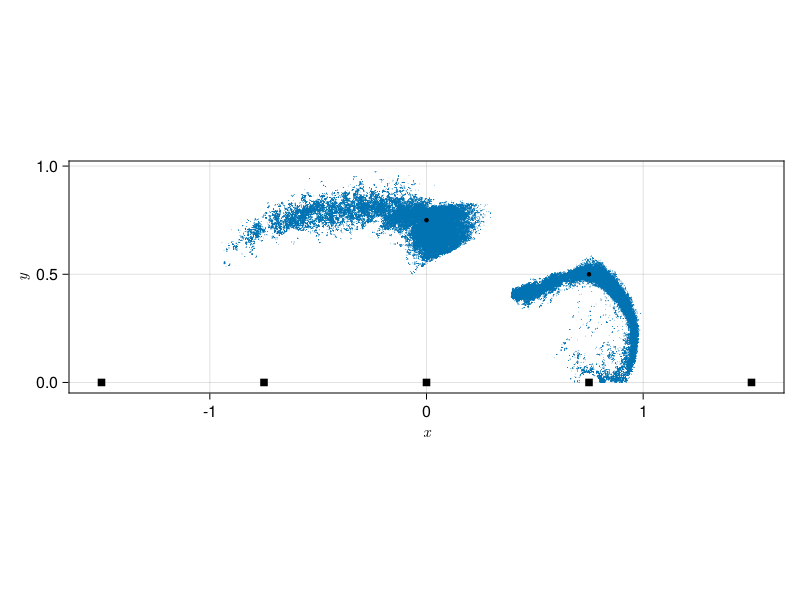

In [386]:
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,ylims=(-1,2))
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=5,color=:black,strokewidth=1)
plot_sensors!(ax,obs)
f

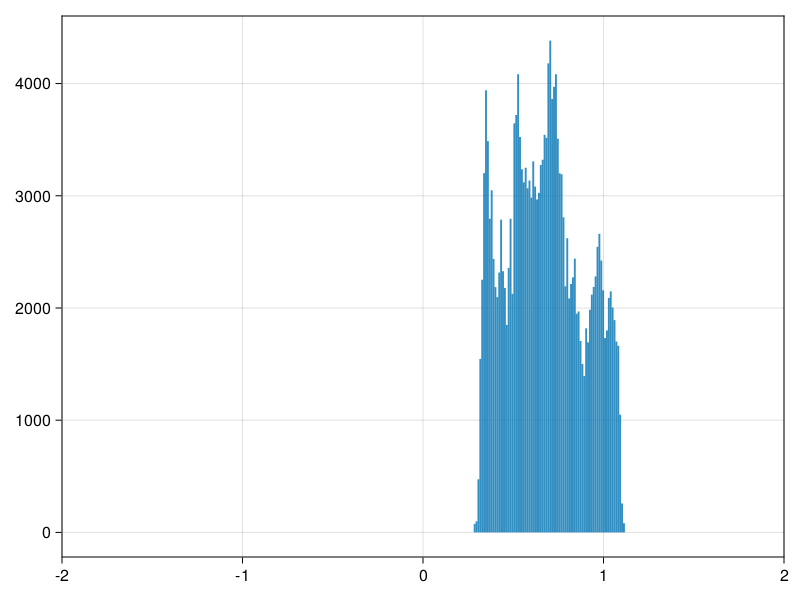

In [387]:
data_histogram(x_data[1][3,:])

In [388]:
gm = classify_by_gmm(3,x_data[1]);

K-means converged with 9 iterations (objv = 238.33365523123885)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 6 dimensions using 200001 data points
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79
┌ Info: K-means with 3000 data points using 9 iterations
│ 142.9 data points per parameter
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141


In [389]:
weights(gm)

3-element Vector{Float64}:
 0.3890680546597267
 0.34589579385270447
 0.2650361514875688

In [390]:
alpha_threshold = 0.15

0.15

In [391]:
Σ = covars(gm)[weights(gm).>alpha_threshold,:];
xm = transpose(means(gm)[weights(gm).>alpha_threshold,:])

6×3 transpose(::Matrix{Float64}) with eltype Float64:
 -0.259923  0.812937   0.922868
  0.781078  0.467895   0.231963
  0.602486  0.846364   0.561495
  0.525584  0.0411973  0.0732556
  0.441776  0.728538   0.644806
  1.41134   1.35536    1.53084

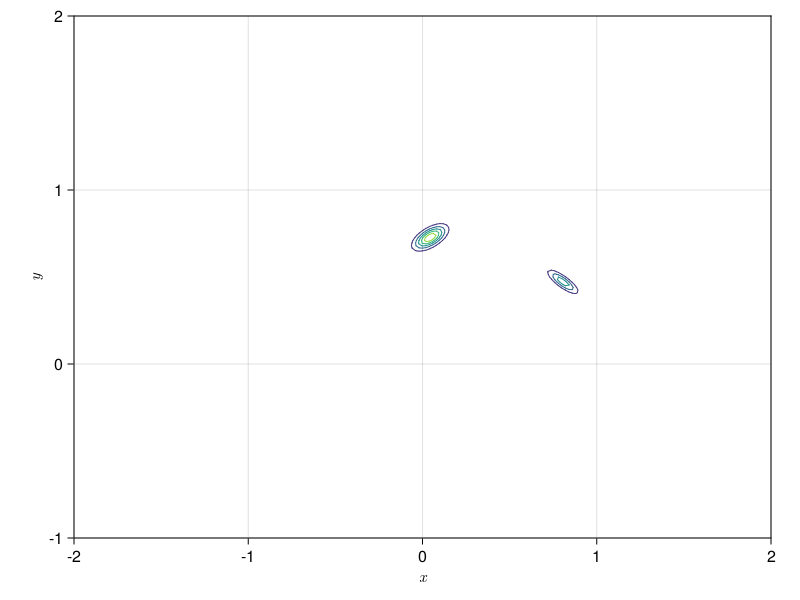

In [393]:
best_comp = 2;
plot_vorticity(xm[:,best_comp],Σ[best_comp],obs,xlims=(-2,2),ylims=(-1,2))

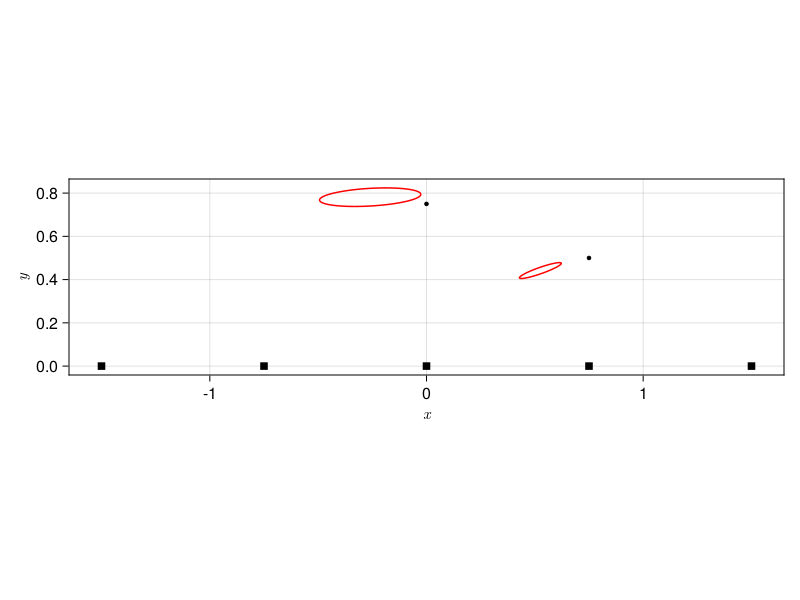

In [396]:
best_comp = 1;
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
#show_vortex_samples!(ax,x_data[1],obs,ylims=(-1,2))
vortex_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs)

scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=5,color=:black,strokewidth=1)
plot_sensors!(ax,obs)
f

#### Plotting the basic data

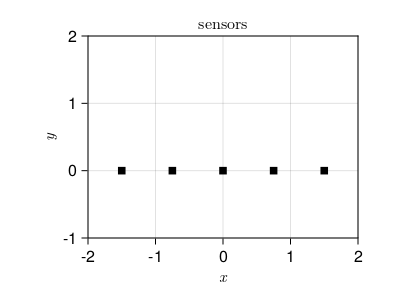

In [355]:
f = Figure(;resolution=(400,300))
ga = f[1, 1]

axleft = Axis(ga;xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

#save("basicdata-3sensor.pdf",f)

f

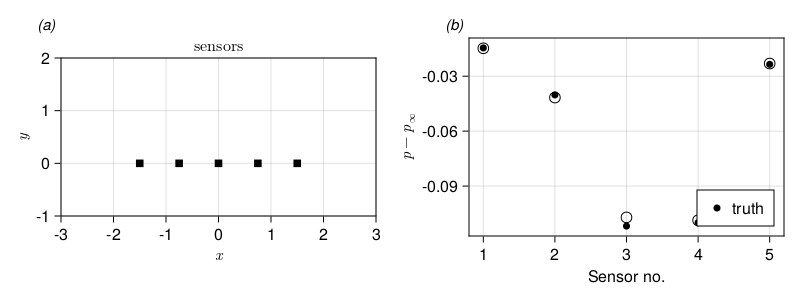

In [397]:
best_comp = 1

f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))

for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

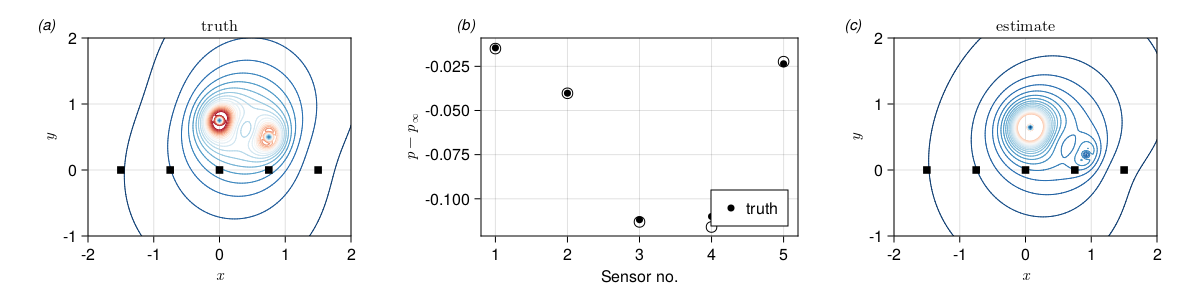

In [401]:
best_comp = 3

l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
plot_pressure_field!(axleft,x_true,obs)
plot_pressure_field!(axright,xm[:,best_comp],obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))

for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-1vortex-1truth-3sensor-case0.pdf",f)

f